In [6]:
import tifffile
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pyvista as pv
import cv2 as cv
import numpy as np
import itertools
import scipy
import time
import pandas as pd
from sklearn.mixture import GaussianMixture as GMM
from skimage.segmentation import mark_boundaries, slic
from scipy.ndimage import generic_filter
from cv2 import fastNlMeansDenoising,fastNlMeansDenoisingMulti, medianBlur
import skimage
from skimage.measure import regionprops
import pyvista
from scipy.linalg import orthogonal_procrustes
import math
import warnings


In [7]:
path1 = 'data/High_res_mask.tif'
high_res = tifffile.imread(path1)

scale = 11.77/ 60

# dowinsizing to 60 microns 
downsized_mask = skimage.transform.rescale(high_res, scale, order=None, mode='reflect',
                                           cval=0, clip=True, preserve_range=True,anti_aliasing=None,
                                           anti_aliasing_sigma=None,channel_axis=None)



In [32]:
# Previous step we found the threshold by porosity is 0.56
# Now we check how much difference it makes in volume and shape of bubbles
thresh_50 = downsized_mask.copy()
thresh_50 [thresh_50 > 0.50] = 1
thresh_50 [thresh_50 <= 0.50] = 0
thresh_50 = thresh_50.astype('uint8')
print ('Number of ice pixels in thresh 50',len(thresh_50[0][thresh_50[0]==1]))

thresh_56 = downsized_mask.copy()
thresh_56 [thresh_56 > 0.56] = 1
thresh_56 [thresh_56 <= 0.56] = 0
thresh_56 = thresh_56.astype('uint8')
print ('Number of ice pixels in thresh 56',len(thresh_56[0][thresh_56[0]==1]))

Number of ice pixels in thresh 50 22272
Number of ice pixels in thresh 56 22226


In [33]:
def extract_properties (regions):
    properties = pd.DataFrame(columns= ['area','area_bbox','area_convex','area_filled','axis_major_length',
                                       'axis_minor_length','bbox','centroid','coords','equivalent_diameter_area',
                                       'euler_number', 'extent','inertia_tensor','solidity','label',
                                        'transformed_coord','matched_high_centroid',
                                        'matched_high_label', 'distance_transformed_high_res'])
    
    for c in properties.columns:
        
        _vals = []
        for r in regions:
            try:
                val = eval('r.{}'.format(c))
                
            except:
                val = 0
                
            _vals.append(val)
        code = 'properties.{} = _vals'.format(c)
        exec(code)

    return properties

    

In [35]:
# Getting labels and regions
labelled_low_res_50 = morphology.label(thresh_50, connectivity=2, background=1)
regions_low_res_50 = regionprops(labelled_low_res_50)

labelled_low_res_56 = morphology.label(thresh_56, connectivity=2, background=1)
regions_low_res_56  = regionprops(labelled_low_res_56)

labelled_high_res = morphology.label(high_res, connectivity=2, background=1)
regions_high_res = regionprops(labelled_high_res)

# properties data frame (pdf)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pdf_low_50 =extract_properties(regions_low_res_50)
    pdf_low_56 =extract_properties(regions_low_res_56)
    pdf_high =extract_properties(regions_high_res).drop(columns = ['transformed_coord','matched_high_centroid', 
                                                                   'matched_high_label','distance_transformed_high_res'])

In [36]:
def draw_rectangules (labelled_image, regions, fontScale):
    img = (labelled_image * 1000)/ labelled_image.max()
    img = img.astype('uint8')
    
    for r in regions[2:]:
        
        for layer in range (r.bbox[0], r.bbox[3]):
            text = '{}'.format(r.label)
            org = ( r.bbox[5],r.bbox[-2])
            font = cv.FONT_HERSHEY_COMPLEX_SMALL
            img[layer] = cv.putText(img[layer],text,org,font,fontScale,200)
            
    return img


In [38]:
Recs_low_res_50 = draw_rectangules (thresh_50, regions_low_res_50,fontScale = 0.7)
Recs_low_res_56 = draw_rectangules (thresh_56, regions_low_res_56,fontScale = 0.7)
Recs_high_res = draw_rectangules (high_res, regions_high_res,fontScale = 2)

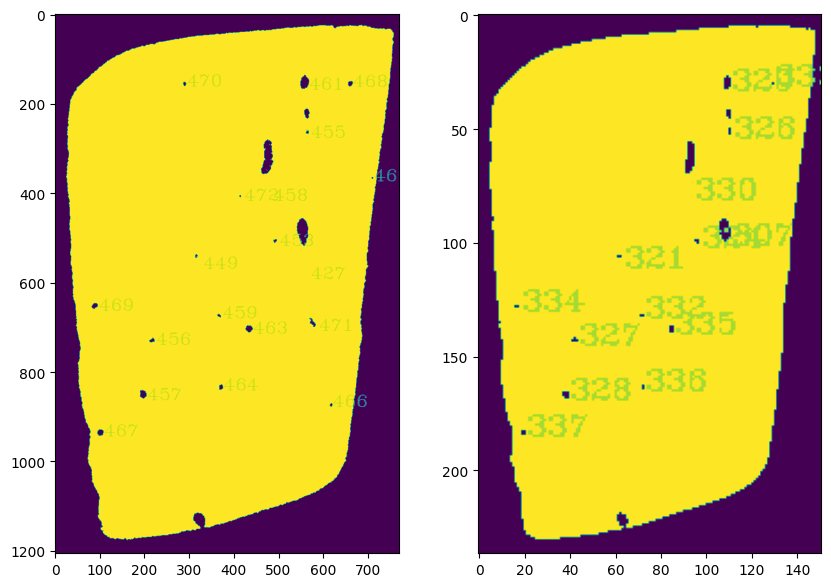

In [64]:
# finding matching points in both volumes
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
plt.imshow(Recs_high_res[513])

fig.add_subplot(1, 2, 2)
plt.imshow(Recs_low_res_50[100])

In [65]:
# finding coresponding regions matching by label manually:

# match points for thresh_50:
Mrg_high_res = [17,18,21,19,68,55,61,46,118,113,116,234,233,238,457,467 ]
Mrg_low_res  = [5 ,6 ,9 ,7 ,43,38,36,32,77 ,74 ,75 ,169,168,172,328,337 ]


In [66]:
def find_transformation_matrix (regions_high_res, regions_low_res, Mrg_high_res, Mrg_low_res, scale):
    
    def get_centroids_by_labels(regions, labels):
        centroids = []
        for l in labels:
            for r in regions:
                if r.label == l:
                    centroids.append(r.centroid)
            
        return centroids

    
    Mrg_centroid_high_res = get_centroids_by_labels (regions=regions_high_res, labels=Mrg_high_res)
   
    Mrg_centroid_high_res = np.array(Mrg_centroid_high_res, dtype= 'float32') 
    print ('shape of given high res ',Mrg_centroid_high_res.shape)
    
    Mrg_centroid_low_res = get_centroids_by_labels (regions=regions_low_res, labels=Mrg_low_res)
    Mrg_centroid_low_res = np.array(Mrg_centroid_low_res, dtype= 'float32') * scale
    print ('shape of given low res ', Mrg_centroid_low_res.shape)
    
    
    a = Mrg_centroid_low_res.mean(axis=0, keepdims=True)
    b = Mrg_centroid_high_res.mean(axis=0, keepdims=True)
    # Compute the transformation matrix
    T, s = orthogonal_procrustes((Mrg_centroid_low_res - a),
                                 (Mrg_centroid_high_res - b ))
    # check the error of transformation matrix
    
    
    transformed = ((Mrg_centroid_low_res - a) @ T) + b
        
    errors = Mrg_centroid_high_res - transformed
    print ('MAE = ', np.abs(errors).mean())
    print (errors.astype('int'))
    return T,a,b,s, errors, transformed,Mrg_centroid_high_res
    
    

In [67]:
# scale obtained from CT scan machine parameters
#scale = 9.887
scale = 60/11.77
affine_matrix,a,b,s, errors, transformed_train,Mrg_centroid_high_res_train = find_transformation_matrix (regions_high_res, regions_low_res_50, Mrg_high_res, Mrg_low_res, scale = scale)

shape of given high res  (16, 3)
shape of given low res  (16, 3)
MAE =  0.60688275
[[ 0  1  0]
 [ 0  0  0]
 [ 0  0  0]
 [ 0  0  0]
 [ 0  0  0]
 [ 0  0  0]
 [ 0  0  0]
 [-1 -7  0]
 [ 0  0  0]
 [ 0  0  0]
 [ 0  0  0]
 [ 0 -1  0]
 [ 0  0  0]
 [ 0  1  0]
 [ 0  0  0]
 [ 1  0 -1]]


In [68]:
def find_nearest_coresponding_center (transformed, centriods_high_res, labels_high_res):
    # length of transformed must be less than centriods_high_res
    def get_distance (pnt, centers):
        min_dist = 100000 #starting with very high number
        for i in range (centers.shape[0]):
            dist = np.linalg.norm(pnt-centers[i])
            if dist < min_dist:
                index = i
                min_dist = dist
        return index, min_dist
    
    nearest_centers = []
    coresponding_labels = []
    dists = []
    for pnt in transformed:
        nearest, min_dist = get_distance(pnt, centriods_high_res)
        nearest_centers.append(centriods_high_res [nearest])
        coresponding_labels.append(labels_high_res[nearest])
        dists.append(min_dist)
        
    return nearest_centers,coresponding_labels,dists

In [69]:
# transforming the points with the developed affine 
pdf_low_50.transformed_coord = list((((np.array(list(pdf_low_50.centroid))*scale) -a ) @ affine_matrix) + b)

pdf_low_50.matched_high_centroid, pdf_low_50.matched_high_label,pdf_low_50.distance_transformed_high_res= find_nearest_coresponding_center (pdf_low_50.transformed_coord,
                                                                        pdf_high.centroid, pdf_high.label)
merged_50 = pdf_low_50.merge(pdf_high, left_on='matched_high_label', right_on='label')


In [70]:
# transforming the points with the developed affine 
pdf_low_56.transformed_coord = list((((np.array(list(pdf_low_56.centroid))*scale) -a ) @ affine_matrix) + b)

pdf_low_56.matched_high_centroid, pdf_low_56.matched_high_label,pdf_low_56.distance_transformed_high_res= find_nearest_coresponding_center (pdf_low_56.transformed_coord,
                                                                        pdf_high.centroid, pdf_high.label)
merged_56 = pdf_low_56.merge(pdf_high, left_on='matched_high_label', right_on='label')

In [71]:
#calculating the volume of 
#resolution_low = 116.444625
resolution_low = 60
resolution_high = 11.777969

volume_low_50 = np.array(merged_50['area_x']) * resolution_low**3
merged_50['volume_low'] = [round(v) for v in volume_low_50]

volume_high = np.array(merged_50['area_y']) * resolution_high**3
merged_50['volume_high'] = [round(v) for v in volume_high]

volume_low_56 = np.array(merged_56['area_x']) * resolution_low**3
merged_56['volume_low'] = [round(v) for v in volume_low_56]

volume_high = np.array(merged_56['area_y']) * resolution_high**3
merged_56['volume_high'] = [round(v) for v in volume_high]


In [72]:
merged_50.to_excel('50%_thresh_60micons_VS_12microns.xlsx')
merged_56.to_excel('56%_thresh_60micons_VS_12microns.xlsx')

In [73]:
merged_50.columns

Index(['area_x', 'area_bbox_x', 'area_convex_x', 'area_filled_x',
       'axis_major_length_x', 'axis_minor_length_x', 'bbox_x', 'centroid_x',
       'coords_x', 'equivalent_diameter_area_x', 'euler_number_x', 'extent_x',
       'inertia_tensor_x', 'solidity_x', 'label_x', 'transformed_coord',
       'matched_high_centroid', 'matched_high_label',
       'distance_transformed_high_res', 'area_y', 'area_bbox_y',
       'area_convex_y', 'area_filled_y', 'axis_major_length_y',
       'axis_minor_length_y', 'bbox_y', 'centroid_y', 'coords_y',
       'equivalent_diameter_area_y', 'euler_number_y', 'extent_y',
       'inertia_tensor_y', 'solidity_y', 'label_y', 'volume_low',
       'volume_high'],
      dtype='object')

In [279]:
#shape ratio (SR) = major_axis/minor_axis
ep = 0.000001 # to prevent getting infinite values
SR_high_50 = merged_50.axis_minor_length_y*100 / (merged_50.axis_major_length_y+ep)
SR_low_50 = merged_50.axis_minor_length_x*100 / (merged_50.axis_major_length_x+ep)
shape_error_50 = SR_high_50 - SR_low_50

SR_high_56 = merged_56.axis_minor_length_y*100 / (merged_56.axis_major_length_y+ep)
SR_low_56 = merged_56.axis_minor_length_x*100 / (merged_56.axis_major_length_x+ep)
shape_error_56 = SR_high_56 - SR_low_56

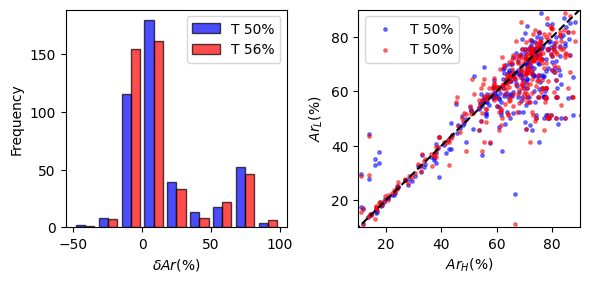

In [285]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
bins = np.linspace(-50, 100, 10)
axs[0].hist([shape_error_50.ravel(), shape_error_56.ravel()], bins,
         label=['T 50%', 'T 56%'], color=['blue', 'red'], alpha=0.7,edgecolor = 'black')
axs[0].legend(loc='upper right')
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('$\delta Ar(\%)$')

axs[1].scatter(SR_high_50,SR_low_50,s=6,alpha=0.5, color = 'blue',label='T 50%')
axs[1].scatter(SR_high_56,SR_low_56,s=6,alpha=0.5, color = 'red',label='T 50%')
axs[1].plot([0, 100], [0, 100],  linestyle='--', color = 'black')
axs[1].legend(loc='upper left')
axs[1].set_ylabel('$Ar_{L}(\%)$')
axs[1].set_xlabel('$Ar_{H}(\%)$')
axs[1].set_ylim(10,90)
axs[1].set_xlim(10,90)

plt.tight_layout()
plt.savefig('SRerror_hist.pdf', dpi = 400)

plt.figure(figsize=(4, 4))
plt.scatter(merged_50.volume_high[1:]*1e-9, shape_error_50[1:],s=6,alpha=0.5, color = 'blue',label='Thresh 50%')
plt.scatter(merged_56.volume_high[1:]*1e-9, shape_error_56[1:],s=6,alpha=0.5, color = 'red',label='Thresh 56%')
plt.plot([0, 0.1], [0, 0],  linestyle='--', color = 'black')

plt.ylim(-0.3,0.4)
plt.xlim(0.0001,0.05)
plt.xlabel('$V_{H} (mm^3)$')
plt.ylabel('$Error_{sr}(\%)$')
plt.legend()
plt.tight_layout()
plt.savefig('vh_error.pdf', dpi = 400)

# Volume fraction = bubble volume in low_res / bubble volume in high-res 
vf_50 = merged_50.volume_low *100/ merged_50.volume_high
vf_56 = merged_56.volume_low *100/ merged_56.volume_high

plt.figure(figsize=(4, 4))
plt.scatter(merged_50.volume_high[1:]*1e-9,vf_50[1:],s=6,alpha=0.5, color = 'blue',label='Thresh 50%')
plt.scatter(merged_56.volume_high[1:]*1e-9,vf_56[1:],s=6,alpha=0.5, color = 'red',label='Thresh 56%')
plt.plot([-1000000, 1e8], [100, 100],  linestyle='--', color = 'black')
plt.xlim(-0.001,0.05)
plt.ylim(0,120)
plt.xlabel('$V_{H} (mm^3)$')
plt.ylabel('$V_{f}(\%)$')
plt.legend()
plt.tight_layout()
plt.savefig('vf_V.pdf', dpi = 400)

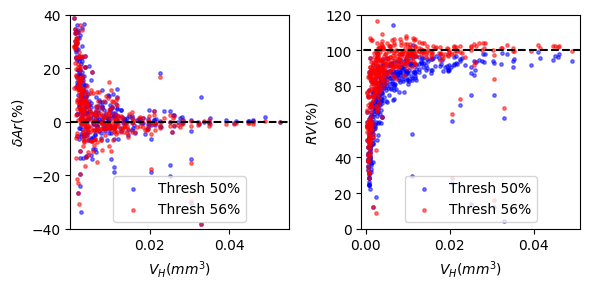

In [290]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
# Display the images on the subplots
axs[0].scatter(merged_50.volume_high[1:]*1e-9, shape_error_50[1:],s=6,alpha=0.5, color = 'blue',label='Thresh 50%')
axs[0].scatter(merged_56.volume_high[1:]*1e-9, shape_error_56[1:],s=6,alpha=0.5, color = 'red',label='Thresh 56%')
axs[0].plot([0, 0.1], [0, 0],  linestyle='--', color = 'black')
axs[0].set_ylim(-40,40)
axs[0].set_xlim(0.0001,0.055)
axs[0].set_xlabel('$V_{H} (mm^3)$')
axs[0].set_ylabel('$\delta Ar(\%)$')
axs[0].legend(loc='lower center')

vf_50 = merged_50.volume_low*100 / merged_50.volume_high
vf_56 = merged_56.volume_low*100 / merged_56.volume_high

axs[1].scatter(merged_50.volume_high[1:]*1e-9,vf_50[1:],s=6,alpha=0.5, color = 'blue',label='Thresh 50%')
axs[1].scatter(merged_56.volume_high[1:]*1e-9,vf_56[1:],s=6,alpha=0.5, color = 'red',label='Thresh 56%')
axs[1].plot([-1000000, 1e8], [100, 100],  linestyle='--', color = 'black')
axs[1].set_xlim(-0.001,0.051)
axs[1].set_ylim(0,120)
axs[1].set_xlabel('$V_{H} (mm^3)$')
axs[1].set_ylabel('$RV(\%)$')
axs[1].legend(loc='lower center')
plt.tight_layout()
plt.savefig('vf_V_and_error_V.pdf', dpi = 400)